# Notes on eye fitting

# Notes on reprojection

We want to find the gaze direction. The first steps, not detailled here is to fit
and reproject the pupil as described in Wallace and Kehr. 

This will give us `phi`, `theta` and `radius` of the pupil. These are angles in
camera coordinates. We want to convert them to angles in world coordinates.

The first step is to go from angles in camera coordinates to gaze vector in the same
reference frame. This is done by the function `pupil_to_vector` in `eye.py`.

In [5]:
# small helper to plot a circle
import numpy as np


def plot_circle(ax, x, y, z, r, n=100):
    # Get circle discrete points in z-plane
    # Convert to Cartesian coordinates
    # Set the 3rd coordinate to a fixed value
    points = r * np.exp(1j * np.linspace(0, 2 * np.pi, n))
    u, v = np.real(points), np.imag(points)
    w = np.repeat(0, n)
    # Plot the circle
    ax.plot(u + x, v + y, w + z, color="b", alpha=0.5)
    ax.plot(u + x, w + y, v + z, color="r", alpha=0.5)
    ax.plot(w + x, u + y, v + z, color="g", alpha=0.5)
    # Plot the center
    ax.scatter(x, y, z, color="black")

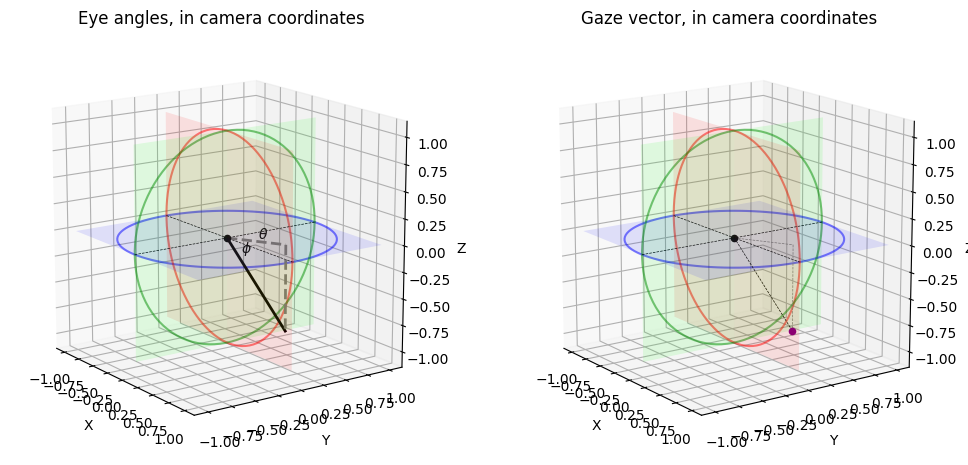

In [49]:
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from cottage_analysis.eye_tracking.utils import get_gaze_vector

fig = plt.figure(figsize=(12, 6))

phi = np.deg2rad(20)
theta = np.deg2rad(30)

gaze_vec = get_gaze_vector(phi, theta)

for iax in range(2):
    ax = fig.add_subplot(1, 2, 1 + iax, projection="3d", aspect="equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Add unit circle on XY plane
    plot_circle(ax, 0, 0, 0, 1)

    a = np.array([(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0)])
    R1 = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R2 = (R1[::-1].T)[:, [1, 0, 2]]
    R3 = (R1[::-1])[:, [1, 0, 2]]
    f = lambda a, r: np.matmul(r, a.T).T
    g = lambda a, r: [a, f(a, r), f(f(a, r), r), f(f(f(a, r), r), r)]

    # plot the X and Y axes on the Z=0 plane
    ax.plot([-1, 1], [0, 0], [0, 0], color="black", linestyle="--", lw=0.5)
    ax.plot([0, 0], [-1, 1], [0, 0], color="black", linestyle="--", lw=0.5)

    if iax:
        ax.scatter(gaze_vec[0], gaze_vec[1], gaze_vec[2], color="purple")
        ls = "--"
        lw = 0.5
        ax.set_title("Gaze vector, in camera coordinates")
    else:
        ls = "-"
        lw = 2
        # annotate the angle between the gaze vector and the Z axis
        ax.text(0.2, 0.2, 0, r"$\theta$")
        ax.text(0.5, -0.2, 0, r"$\phi$")
        ax.set_title("Eye angles, in camera coordinates")

    ax.plot(
        [0, gaze_vec[0]],
        [0, gaze_vec[1]],
        [0, gaze_vec[2]],
        color="black",
        linestyle=ls,
        lw=lw,
    )
    # also plot the projection of the gaze vector on the XY plane
    ax.plot(
        [0, gaze_vec[0]], [0, gaze_vec[1]], [0, 0], color="gray", linestyle="--", lw=lw
    )
    # and the projection on the YZ plane
    ax.plot(
        [gaze_vec[0], gaze_vec[0]],
        [gaze_vec[1], gaze_vec[1]],
        [0, gaze_vec[2]],
        color="gray",
        linestyle="--",
        lw=lw,
    )

    import mpl_toolkits.mplot3d as mp3d

    for i, ind, r in zip(range(3), [[0, 1, 2], [2, 0, 1], [1, 2, 0]], [R1, R2, R3]):
        xy = g(a[:, ind], r)
        for x in xy:
            face1 = mp3d.art3d.Poly3DCollection([x], alpha=0.1, linewidth=1)
            face1.set_facecolor((i // 2, i % 2, i == 0, 0.5))
            ax.add_collection3d(face1)

    # Set camera view
    ax.view_init(elev=15, azim=-35)

## Transforming to world coordinates

This is simple if we have the rotation matrix from camera to world coordinates. we jsut
take the gaze vector in camera coordinates and multiply it by the inverse of the
rotation matrix.




# Older idea without reprojection

Summary of the discussion with Petr. All in 2D for now

## Eye

First we have an eye, and there is a pupil. The eye is a disk defined by its centre and
radius. The pupil is defined by the angle on the eye and its length (which would be radius in 3D).

(-100.0, 100.0)

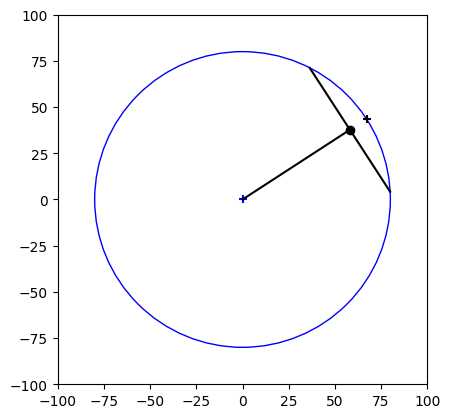

In [1]:
import matplotlib.pyplot as plt
import numpy as np


eye = dict(centre=[0, 0], radius=80, color="blue")
pupil = dict(angle=np.deg2rad(33), radius=40, color="black")


def find_pupil(eye_center, eye_radius, pupil_angle, pupil_radius):
    out = dict()
    pupil_axis = (
        np.array([np.cos(pupil_angle), np.sin(pupil_angle)]) * eye_radius - eye_center
    )
    out["on_eye"] = pupil_axis
    # with the https://en.wikipedia.org/wiki/Intersecting_chords_theorem we can find the
    # centre of the chord
    pupil_to_centre = np.sqrt(eye_radius**2 - pupil_radius**2)
    pupil_centre = (
        np.array([np.cos(pupil_angle), np.sin(pupil_angle)]) * pupil_to_centre
        - eye_center
    )
    out["centre"] = pupil_centre
    for side, sign in zip(["left", "right"], [1, -1]):
        out[side] = (
            pupil_centre
            + np.array(
                [
                    np.cos(pupil_angle + sign * np.pi / 2),
                    np.sin(pupil_angle + sign * np.pi / 2),
                ]
            )
            * pupil_radius
        )
    return out


pupil.update(
    find_pupil(
        eye_center=eye["centre"],
        eye_radius=eye["radius"],
        pupil_angle=pupil["angle"],
        pupil_radius=pupil["radius"],
    )
)


def plot_eye(ax, eye, pupil):
    eye_circle = plt.Circle(
        eye["centre"], eye["radius"], facecolor="None", edgecolor=eye["color"]
    )

    ax.add_artist(eye_circle)
    ax.scatter(eye["centre"][0], eye["centre"][1], marker="+", color=eye["color"])
    ax.scatter(pupil["centre"][0], pupil["centre"][1], marker="o", color=pupil["color"])
    ax.scatter(pupil["on_eye"][0], pupil["on_eye"][1], marker="+", color=pupil["color"])

    ax.plot(
        [pupil["left"][0], pupil["right"][0]],
        [pupil["left"][1], pupil["right"][1]],
        color=pupil["color"],
    )
    ax.plot(
        [eye["centre"][0], pupil["centre"][0]],
        [eye["centre"][1], pupil["centre"][1]],
        color=pupil["color"],
    )


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)

# Camera

We have a camera, let's put it just below the eye for now

(-3.0, 2.0)

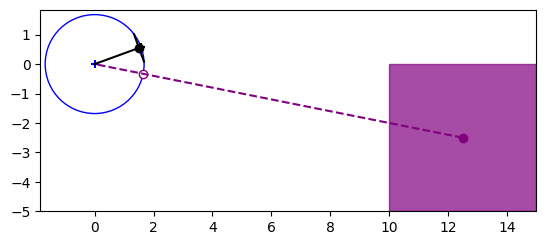

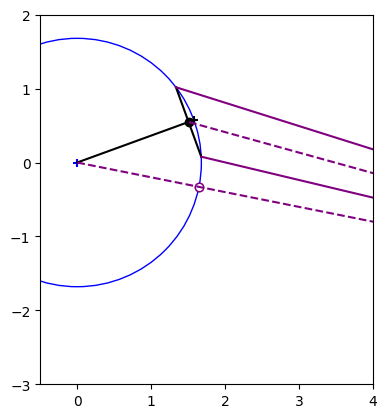

In [2]:
camera = dict(bottom_left=np.array([10, -5]), width=5, height=5, color="purple")
eye = dict(centre=[0, 0], radius=3.36 / 2, color="blue")
pupil = dict(angle=np.deg2rad(20), radius=0.5, color="black")

pupil.update(
    find_pupil(
        eye_center=eye["centre"],
        eye_radius=eye["radius"],
        pupil_angle=pupil["angle"],
        pupil_radius=pupil["radius"],
    )
)
camera["centre"] = camera["bottom_left"] + np.array(
    [camera["width"] / 2, camera["height"] / 2]
)
# find the reflection
# eye circle is x**2 + y**2 = r**2
# line passed by 0,0 and camera['centre'],
# so y = camera['centre'][1]/camera['centre'][0] x = a x
# x**2 (1 + a**2) = r**2
# x = +/- np.sqrt(r**2 / (1 + a**2)) negative being inside the mouse
# y = a * np.sqrt(r**2 / (1 + a**2))
a = camera["centre"][1] / camera["centre"][0]
x_r = np.sqrt(eye["radius"] ** 2 / (1 + a**2))
y_r = x_r * a
reflection = [x_r, y_r]
eye["reflection"] = reflection


def plot_camera(ax, camera, eye=None, pupil=None):
    camera_rect = plt.Rectangle(
        camera["bottom_left"],
        camera["width"],
        camera["height"],
        color=camera["color"],
        alpha=0.7,
    )
    ax.add_artist(camera_rect)
    ax.scatter(camera["centre"][0], camera["centre"][1], color=camera["color"])
    ax.set_xlim(
        min(-eye["radius"] * 1.1, camera["bottom_left"][0]),
        max(eye["radius"] * 1.1, camera["bottom_left"][0] + camera["width"]),
    )
    ax.set_ylim(
        min(-eye["radius"] * 1.1, camera["bottom_left"][1]),
        max(eye["radius"] * 1.1, camera["bottom_left"][1] + camera["height"]),
    )

    if eye is not None:
        ax.plot(
            [camera["centre"][0], eye["centre"][0]],
            [camera["centre"][1], eye["centre"][1]],
            color=camera["color"],
            ls="--",
        )
        ax.scatter(
            eye["reflection"][0],
            eye["reflection"][1],
            edgecolor=camera["color"],
            facecolor="w",
        )

    if pupil is not None:
        for what in ["left", "right", "centre"]:
            ax.plot(
                [camera["centre"][0], pupil[what][0]],
                [camera["centre"][1], pupil[what][1]],
                color=camera["color"],
                ls="--" if what == "centre" else "-",
            )
    return camera_rect


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye, pupil=pupil)
ax.scatter(x_r, y_r, edgecolor=camera["color"], facecolor="w")
ax.set_xlim(-0.5, 4)
ax.set_ylim(-3, 2)

# Now add the img plane

(-4.0, 1.5)

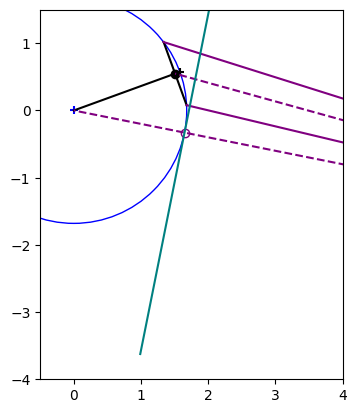

In [3]:
# use sin as we are always on the right half
angle_to_camera = np.arcsin(reflection[1] / eye["radius"])
img_plane = dict(color="teal")
for side, sign in zip(["left", "right"], [1, -1]):
    img_plane[side] = (
        reflection
        + np.array(
            [
                np.cos(angle_to_camera + sign * np.pi / 2),
                np.sin(angle_to_camera + sign * np.pi / 2),
            ]
        )
        * eye["radius"]
        * 2
    )


def plot_image_plane(ax, img_plane):
    ax.plot(
        [img_plane["left"][0], img_plane["right"][0]],
        [img_plane["left"][1], img_plane["right"][1]],
        color=img_plane["color"],
    )


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye, pupil=pupil)
plot_image_plane(ax, img_plane)
ax.set_xlim(-0.5, 4)
ax.set_ylim(-4, 1.5)

# Find the radius

The aim is to find $\theta$ the angle of gaze relative to the camera

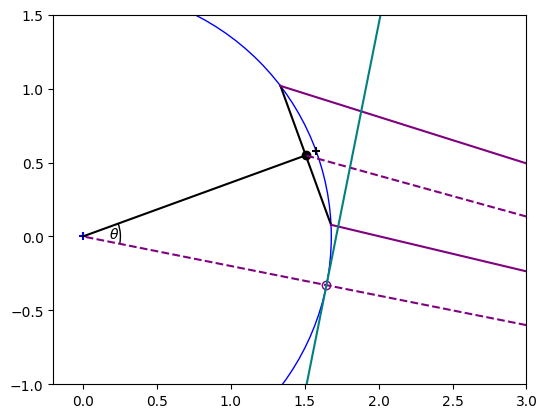

In [4]:
from cottage_analysis.utilities.plot_utils import AngleAnnotation

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye, pupil=pupil)
plot_image_plane(ax, img_plane)
ax.set_xlim(-0.2, 3)
ax.set_ylim(-1, 1.5)

theta = AngleAnnotation(
    [0, 0], eye["reflection"], pupil["centre"], ax=ax, text=r"$\theta$"
)

ax.plot(
    [pupil["centre"][0], eye["reflection"][0]],
    [pupil["centre"][0], eye["reflection"][0]],
)

Intersecting chord says that $r^2 - d^2 = |p_1p_2|$